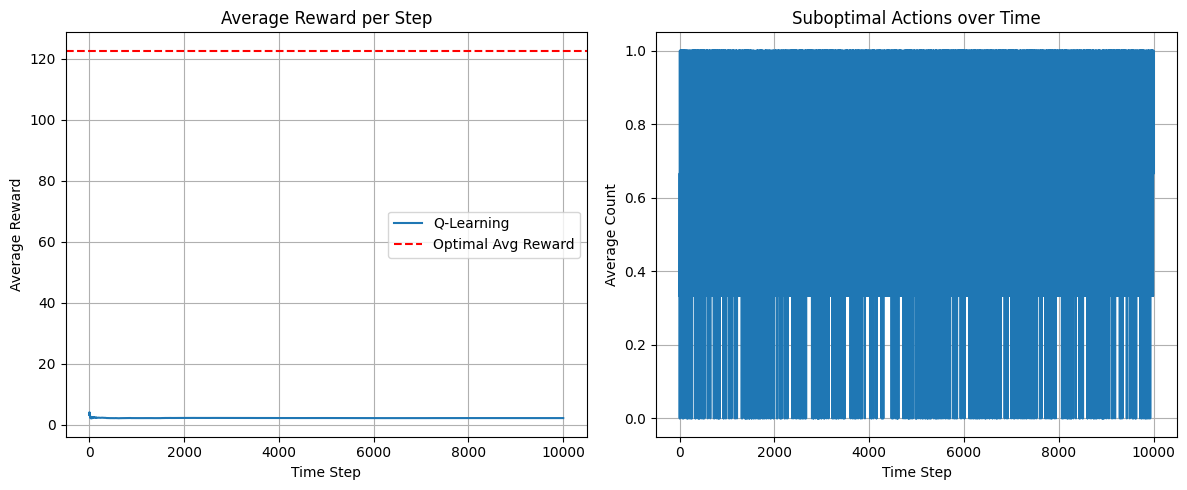

Optimal Policy from Policy Iteration: [0 1 1]
Value Function: [118.73719467 122.99351449 126.35624229]


In [ ]:

# AI Task Scheduling MDP - Q-Learning + Policy Iteration Comparison

import numpy as np
import matplotlib.pyplot as plt
from Fin_BK_UCB_TS_QL_RL_ParallelPolicies import BK_UCB_Q_Learning, BK2_UCB_Q_Learning, TS_Q_Learning, UCB_Q_Learning

# --- MDP Definition ---
S = 3
A = 3

r_true = np.array([
    [4, 2, 0],
    [2, 6, 0],
    [-2, 8, 0]
])

P_s = np.array([
    [0.6, 0.3, 0.1],
    [0.2, 0.5, 0.3],
    [0.1, 0.3, 0.6]
])

P_true = np.zeros((S, A, S))
for s in range(S):
    for a in range(A):
        P_true[s, a, :] = P_s[s]

# --- Policy Iteration ---
def policy_iteration(P, R, gamma=0.95, max_iter=1000):
    policy = np.zeros(S, dtype=int)
    V = np.zeros(S)

    for _ in range(max_iter):
        # Policy Evaluation
        while True:
            V_prev = V.copy()
            for s in range(S):
                a = policy[s]
                V[s] = R[s,a] + gamma * np.dot(P[s,a,:], V_prev)
            if np.max(np.abs(V - V_prev)) < 1e-6:
                break

        # Policy Improvement
        stable = True
        for s in range(S):
            old_action = policy[s]
            policy[s] = np.argmax([R[s,a] + gamma * np.dot(P[s,a,:], V) for a in range(A)])
            if policy[s] != old_action:
                stable = False
        if stable:
            break
    return policy, V

# --- Q-Learning ---
N_EPISODES = 3
HORIZON = 10000
GAMMA = 0.95
ALPHA = 0.1
EPSILON = 1.0
EPSILON_MIN = 0.05
DECAY = 0.999

def q_learning_simulation(opt_policy):
    avg_rewards = np.zeros(HORIZON)
    suboptimal_counts = np.zeros(HORIZON)

    for ep in range(N_EPISODES):
        Q = np.zeros((S, A))
        state = np.random.randint(S)
        cumulative_reward = 0

        for t in range(HORIZON):
            global EPSILON
            if np.random.rand() < EPSILON:
                action = np.random.randint(A)
            else:
                action = np.argmax(Q[state])

            next_state = np.random.choice(S, p=P_true[state, action])
            reward = r_true[state, action]
            best_next = np.max(Q[next_state])
            Q[state, action] += ALPHA * (reward + GAMMA * best_next - Q[state, action])
            cumulative_reward += reward

            if action != opt_policy[state]:
                suboptimal_counts[t] += 1

            avg_rewards[t] += cumulative_reward / (t + 1)
            state = next_state

        EPSILON = max(EPSILON * DECAY, EPSILON_MIN)

    avg_rewards /= N_EPISODES
    suboptimal_counts /= N_EPISODES
    return avg_rewards, suboptimal_counts

# --- Run Both Methods ---
optimal_policy, V_star = policy_iteration(P_true, r_true)
avg_rewards, subopt_actions = q_learning_simulation(optimal_policy)

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_rewards, label='Q-Learning')
plt.axhline(np.mean(V_star), color='r', linestyle='--', label='Optimal Avg Reward')
plt.title("Average Reward per Step")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(subopt_actions, label='Suboptimal Actions')
plt.title("Suboptimal Actions over Time")
plt.xlabel("Time Step")
plt.ylabel("Average Count")
plt.grid()

plt.tight_layout()
plt.savefig("ai_mdp_comparison_plot.png")
plt.show()

# Output for report
print("Optimal Policy from Policy Iteration:", optimal_policy)
print("Value Function:", V_star)

1. MDP Setup
States (S = 3): These represent different scenarios or tasks.

Actions (A = 3): These represent different scheduling decisions or moves.

Reward Matrix r_true:

Each element r_true[s, a] represents the immediate reward for taking action a in state s.

Transition Matrix P_true:

For simplicity, the transition probabilities from a state to other states are the same across all actions, taken from P_s.

2. Policy Iteration (Model-Based RL)
This method assumes full knowledge of the environment (P_true and r_true).

Steps:

Policy Evaluation:

Computes the value function V for a fixed policy by solving the Bellman equation iteratively until convergence.

Policy Improvement:

Updates the policy by choosing the action that maximizes the expected reward given the current value function.

The process repeats until the policy is stable (no longer changes).

Output:

optimal_policy: Best action to take in each state.

V_star: Value function for the optimal policy.

3. Q-Learning (Model-Free RL)
This method learns from interaction, without knowing the transition or reward functions.

Key Points:

Uses a Q-table Q[s,a] to estimate the value of taking action a in state s.

Chooses actions using an ε-greedy strategy (mostly greedy, but occasionally random).

Updates the Q-values after each step using the Bellman update rule.

Evaluation:

Runs multiple episodes of learning.

Tracks:

avg_rewards[t]: average reward up to each timestep.

suboptimal_counts[t]: how often the action taken differs from the optimal policy from Policy Iteration.

4. Comparison & Visualization
Average Reward Plot: Shows how cumulative rewards from Q-learning evolve compared to the optimal expected reward.

Suboptimal Actions Plot: Shows how frequently Q-learning selects suboptimal actions over time.

This helps assess how quickly and accurately Q-learning converges to the optimal policy.

5. Final Output
The notebook prints:

The optimal policy found via policy iteration.

Its corresponding value function.

This serves as the benchmark to evaluate Q-learning’s performance.

In [ ]:
## UCB1 and Thompson Sampling: Bernoulli Rewards

#We simulate a multi-armed bandit environment with **Bernoulli-distributed rewards**.

#- **UCB1** (Auer et al. 2002): Selects arms with the highest upper confidence bound.
#- **Thompson Sampling (TS)**: Maintains Beta posteriors for success probabilities and samples from them to select arms.

#This section compares both methods in terms of cumulative reward over 500 steps.

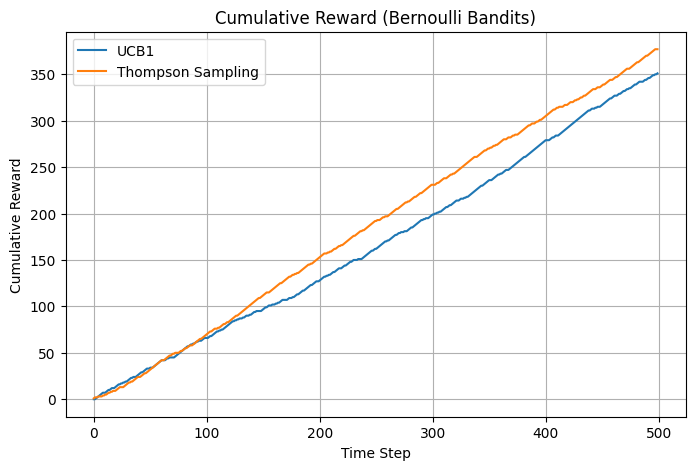

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, means):
        self.means = means
        self.n_arms = len(means)

    def pull(self, arm):
        return np.random.binomial(1, self.means[arm])

class UCB1:
    def __init__(self, n_arms):
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        if 0 in self.counts:
            return np.argmin(self.counts)
        ucb = self.values + np.sqrt(2 * np.log(self.t) / self.counts)
        return np.argmax(ucb)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class ThompsonSampling:
    def __init__(self, n_arms):
        self.alphas = np.ones(n_arms)
        self.betas = np.ones(n_arms)

    def select_arm(self):
        return np.argmax(np.random.beta(self.alphas, self.betas))

    def update(self, arm, reward):
        self.alphas[arm] += reward
        self.betas[arm] += 1 - reward

def run_simulation(env, agent, T=500):
    rewards, cumulative = [], []
    total = 0
    for _ in range(T):
        arm = agent.select_arm()
        reward = env.pull(arm)
        agent.update(arm, reward)
        total += reward
        rewards.append(reward)
        cumulative.append(total)
    return cumulative

env = BanditEnvironment([0.2, 0.5, 0.75])
T = 500
ucb = UCB1(env.n_arms)
ts = ThompsonSampling(env.n_arms)

ucb_rewards = run_simulation(env, ucb, T)
ts_rewards = run_simulation(env, ts, T)

plt.figure(figsize=(8,5))
plt.plot(ucb_rewards, label="UCB1")
plt.plot(ts_rewards, label="Thompson Sampling")
plt.title("Cumulative Reward (Bernoulli Bandits)")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

## Section 1: UCB1 and Thompson Sampling – Bernoulli Rewards

In this section, we simulate a classic multi-armed bandit problem where each arm provides **Bernoulli-distributed rewards** — that is, the reward is either 0 or 1 with a fixed probability of success.

We compare two widely used strategies:

### UCB1 (Upper Confidence Bound)
- UCB1 selects the arm with the highest upper confidence bound.
- Each arm's upper bound is based on its sample mean plus an exploration bonus.
- Formula:  
  \[
  \text{UCB}_i = \bar{x}_i + \sqrt{\frac{2 \log t}{n_i}}
  \]  
  where:
  - \( \bar{x}_i \) is the average reward of arm \( i \),
  - \( n_i \) is the number of times arm \( i \) was pulled,
  - \( t \) is the current timestep.
- **Strength**: No prior assumptions needed; simple and effective.
- **Limitation**: Can over-explore suboptimal arms early on.

### Thompson Sampling (Beta-Bernoulli)
- A Bayesian method that models each arm's reward with a Beta distribution.
- At each step, it samples a probability from each arm’s posterior and selects the arm with the highest sample.
- The posterior updates using:
  - \(\alpha \leftarrow \alpha + r\)
  - \(\beta \leftarrow \beta + (1 - r)\)
  where \( r \) is the observed reward (0 or 1).
- **Strength**: Efficient, smooth exploration.
- **Limitation**: Slightly more complex to understand; sensitive to prior (though Beta(1,1) is standard).

### Takeaway
- Thompson Sampling often outperforms UCB1 in practice due to adaptive exploration.
- UCB1 remains a solid, interpretable baseline with theoretical guarantees.

In [ ]:
## UCB1 and Thompson Sampling: Gaussian Rewards

#We now simulate a multi-armed bandit problem with **Gaussian-distributed rewards**.

#- **UCB1** still applies, using sample means and standard deviations.
#- **Thompson Sampling (Gaussian)** models each arm with a normal prior and updates mean/posterior precision based on observed variance.

#Cumulative rewards are plotted to compare performance.

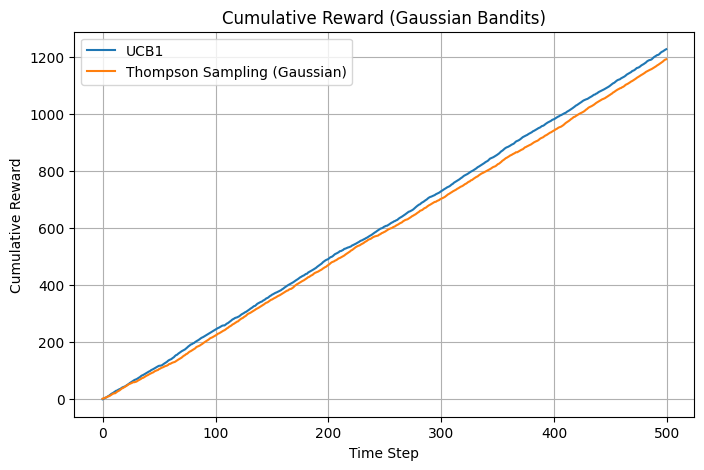

In [ ]:
class GaussianBanditEnvironment:
    def __init__(self, means, variances):
        self.means = means
        self.variances = variances
        self.n_arms = len(means)

    def pull(self, arm):
        return np.random.normal(self.means[arm], np.sqrt(self.variances[arm]))

class UCB1:
    def __init__(self, n_arms):
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.t = 0

    def select_arm(self):
        self.t += 1
        if 0 in self.counts:
            return np.argmin(self.counts)
        ucb = self.values + np.sqrt(2 * np.log(self.t) / self.counts)
        return np.argmax(ucb)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class ThompsonSamplingGaussian:
    def __init__(self, n_arms):
        self.means = np.zeros(n_arms)
        self.precisions = np.ones(n_arms)
        self.counts = np.zeros(n_arms)

    def select_arm(self):
        samples = np.random.normal(self.means, 1 / np.sqrt(self.precisions))
        return np.argmax(samples)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        delta = reward - self.means[arm]
        self.means[arm] += delta / n
        self.precisions[arm] += delta * (reward - self.means[arm])

def run_simulation(env, agent, T=500):
    rewards, cumulative = [], []
    total = 0
    for _ in range(T):
        arm = agent.select_arm()
        reward = env.pull(arm)
        agent.update(arm, reward)
        total += reward
        rewards.append(reward)
        cumulative.append(total)
    return cumulative

env = GaussianBanditEnvironment([1.0, 2.0, 2.5], [0.5, 0.5, 0.5])
T = 500
ucb = UCB1(env.n_arms)
ts = ThompsonSamplingGaussian(env.n_arms)

ucb_rewards = run_simulation(env, ucb, T)
ts_rewards = run_simulation(env, ts, T)

plt.figure(figsize=(8,5))
plt.plot(ucb_rewards, label="UCB1")
plt.plot(ts_rewards, label="Thompson Sampling (Gaussian)")
plt.title("Cumulative Reward (Gaussian Bandits)")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

## Section 2: UCB1 and Thompson Sampling – Gaussian Rewards

Now we analyze a more general multi-armed bandit setting with **Gaussian-distributed rewards** — where each arm yields a real-valued reward with a specific mean and variance.

We use the same two strategies as in the Bernoulli case:

### UCB1 (for Gaussian Arms)
- UCB1 still applies, using empirical means plus a confidence interval.
- Assumes rewards are sub-Gaussian (bounded variance).
- Formula:
  \[
  \text{UCB}_i = \bar{x}_i + \sqrt{\frac{2 \log t}{n_i}}
  \]
- **Strength**: No need to model variance explicitly.
- **Limitation**: Less effective when reward variances differ significantly across arms.

### Thompson Sampling (Gaussian-Normal)
- Uses Bayesian updates for Gaussian likelihood with Normal prior.
- Each arm is modeled with:
  - Mean \( \mu_i \)
  - Precision \( \tau_i = 1/\sigma^2_i \)
- The posterior mean and precision are updated based on observations.
- At each step, sample from:
  \[
  \mathcal{N}(\mu_i, 1/\tau_i)
  \]
  and select the arm with the highest sampled value.
- **Strength**: Naturally handles Gaussian noise and continuous rewards.
- **Limitation**: Requires bookkeeping for means and precision.

### Takeaway
- Thompson Sampling is well-suited for Gaussian environments due to its ability to model continuous reward uncertainty.
- UCB1 can still work effectively, especially with small or equal variances.
